```{currentmodule} tskit
```

In [1]:
import io
import pickle

import msprime
import tskit
import numpy as np

def tables_examples():
    nodes = """\
    is_sample   time    population    individual
    1           0       0             0
    1           0       0             0
    1           0       0             1
    0           0.15    0             2
    0           0.6     -1            -1
    0           0.8     -1            -1
    0           1.0     -1            -1
    """
    edges = """\
    left    right   parent  child
    20      80      3       0
    20      80      3       2
    0       100     4       1
    0       20      4       2
    80      100     4       2
    20      80      4       3
    80      100     5       0
    80      100     5       4
    0       20      6       0
    0       20      6       4
    """
    sites = """\
    id    position    ancestral_state
    0     15          A
    1     42          G
    2     60          T
    """
    mutations = """\
    site    node    derived_state    parent    time
    0       4       G                -1        0.9
    1       1       A                -1        0.4
    2       3       C                -1        0.55
    2       0       T                2         0.1
    """
    individuals = """\
    flags    parents    metadata
    0        2,-1       {"name":"Alice"}
    0        2,-1       {"name":"Bob"}
    0        -1,-1      {"name":"Carol"}
    """
    populations = """\
    metadata
    {"name":"GBR","description":"British_in_England_and_Scotland"}
    """  # (NB: can't use spaces in load_text with strict==False)
    ts = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        individuals=io.StringIO(individuals),
        populations=io.StringIO(populations),
        strict=False,
        base64_metadata=False,
    )
    ts.dump("data/tables_example.trees")
    tables = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        sites=io.StringIO(sites),
        mutations=io.StringIO(mutations),
        individuals=io.StringIO(individuals),
        populations=io.StringIO(populations),
        strict=False,
        base64_metadata=False,
    ).dump_tables()
    tables.individuals.metadata_schema = tskit.MetadataSchema({'codec': 'json'})
    tables.populations.metadata = np.where(  # Hack to replace underscores with spaces
        tables.populations.metadata == ord("_"), ord(" "), tables.populations.metadata)
    tables.populations.metadata_schema = tskit.MetadataSchema({'codec': 'json'})
    tables.tree_sequence().dump("data/tables_example_muts.trees")

def construction_example():
    nodes = """\
    id      is_sample   time
    0       1           0
    1       1           0
    2       0           10
    3       1           0
    4       0           20
    """
    edges = """\
    left    right   parent  child
    0       1000    2       0
    0       1000    2       1
    0       1000    4       2
    0       1000    4       3
    """
    sites = """\
    id    position    ancestral_state
    0     500          A
    """
    mutations = """\
    site    node    derived_state    parent
    0       3       G                -1
    """
    ts = tskit.load_text(
        nodes=io.StringIO(nodes),
        edges=io.StringIO(edges),
        sites=io.StringIO(sites),
        mutations=io.StringIO(mutations),
        strict=False,
    )
    ts.dump("data/construction_example.trees")
    

def create_notebook_data():
    tables_examples()
    construction_example()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_tables)=

# Tables and editing

Internally, a tree sequence can be thought of as a set of tables, and {program}`tskit`
provides an interface for dealing with these tables directly. This is particularly
relevant when you wish to {ref}`edit or otherwise modify<sec_tables_editing>`
a tree sequence, although tables are also useful for bulk access to data contained in
the tree sequence, such as the times of all nodes.

There are eight tables that together define a tree sequence, although some may be empty,
and together they form a {class}`TableCollection`.
The tables are defined in the official {program}`tskit` documentation for
{ref}`Table Definitions <tskit:sec_table_definitions>`, and the
{ref}`Tables API <tskit:sec_tables_api>` section in the docs describes how to work with
them. In this tutorial we give some pointers about what you can and cannot do with them.

(sec_tables_correspondence)=

## Correspondence between tables and trees

Consider the following sequence of trees:

In [2]:
ts = tskit.load("data/tables_example.trees")

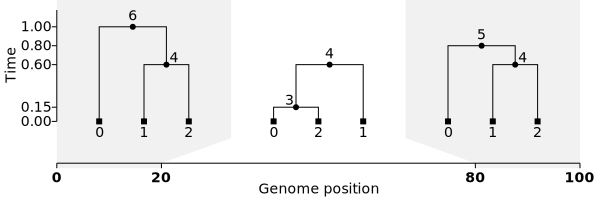

In [3]:
ts.draw_svg(y_axis=True)

Ancestral recombination events have produced three different trees
that relate the three sampled genomes ``0``, ``1``, and ``2`` to each other
along the chromosome of length 100.

(sec_tables_correspondence_nodes_and_edges)=

### Node and edge tables

Each node in each of the above trees represents a particular ancestral genome
(a *haploid* genome; diploid individuals would be represented by two nodes).
Details about each node, including the time it lived, are stored in a
{class}`NodeTable` (details {ref}`here<tskit:sec_mutation_table_definition>`)

In [4]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.00000000,
2,1,0,1,0.00000000,
3,0,0,2,0.15000000,
4,0,-1,-1,0.60000000,
5,0,-1,-1,0.80000000,
6,0,-1,-1,1.00000000,


Importantly, the first column, `id`, is not actually recorded, and is
only shown when printing out node tables (as here) for convenience.
The second column, `flags` records a `1` for the nodes that are *samples*,
i.e., whose entire genealogical history is recorded by these trees.
You can see that the sample nodes are present in all the trees, but other nodes need
not be: for example node 3 is only seen in the middle tree. The `individual` and
`population` columns store an index into the rows of the
{ref}`sec_tables_overview_individuals_and_populations`, or `tskit.NULL` (`-1`)
if the node is not associated with an individual or population. The ``time`` column
records the historical age of the node, with contemporary nodes having a ``time`` of 0.

The way the nodes are related to each other (i.e. the tree topology) is stored
in an {class}`EdgeTable` (details {ref}`here<tskit:sec_edge_table_definition>`).
Since some edges are present in more than one tree (e.g., node 1 inherits from node 4
across the entire sequence), each edge contains not only the IDs of a parent and a child
node, but also the left and right positions which define the genomic region for which it
appears in the trees:

In [5]:
ts.tables.edges

id,left,right,parent,child,metadata
0,20,80,3,0,
1,20,80,3,2,
2,0,100,4,1,
3,0,20,4,2,
4,80,100,4,2,
5,20,80,4,3,
6,80,100,5,0,
7,80,100,5,4,
8,0,20,6,0,
9,0,20,6,4,


Since node 3 is most recent, the edge that says that nodes 0 and 2 inherit
from node 3 on the interval between 0.2 and 0.8 comes first.  Next are the
edges from node 4: there are four of these, as the edge from node 4 to node
1 is shared across the entire sequence, and for each of the three
genomic intervals there is an additional child node. At this
point, we know the full tree on the middle interval.  Finally, edges
specifying the common ancestor of 0 and 4 on the remaining intervals (parents 6
and 5 respectively) allow us to construct all trees across the entire interval.


(sec_tables_correspondence_sites_and_mutations)=

### Site and mutation tables

Most tree sequences have DNA variation data associated with them,
{ref}`stored as mutations overlaid on the trees<sec_what_is_dna_data>`:

In [6]:
ts = tskit.load("data/tables_example_muts.trees")

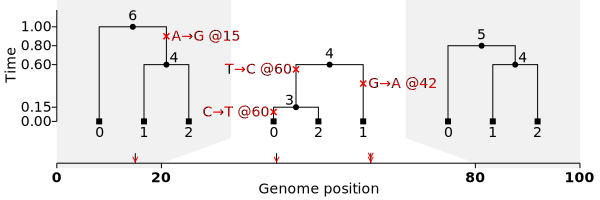

In [7]:
mut_labels = {}  # An array of labels for the mutations, listing position & allele change
for mut in ts.mutations():  # This entire loop is just to make pretty labels
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = "{}→{} @{:g}".format(prev, mut.derived_state, site.position)
ts.draw_svg(y_axis=True, mutation_labels=mut_labels)

There are four mutations in the depiction above,
marked by red crosses: one above node ``4`` on the first tree which records an A to G
transition at position 15, another above node ``1`` in the second tree which records a G
to A transition at position 42, and the final two above nodes ``0`` and ``3`` recording
transitions, both at position 60, on the second tree. The positions are recorded in the
{class}`SiteTable` (details {ref}`here<tskit:sec_site_table_definition>`):

In [8]:
ts.tables.sites

id,position,ancestral_state,metadata
0,15,A,
1,42,G,
2,60,T,


As with node tables, the ``id`` column is **not** actually recorded, but is
implied by the position in the table.  The mutations themselves are recorded in the
{class}`MutationTable` (details {ref}`here<tskit:sec_mutation_table_definition>`).
This associates each mutation with a site ID, the ID of the node above which the
mutation occurs, the derived state to which the allele has mutated, and (optionally) a
time at which the mutation occured.

In [9]:
ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,4,0.90000000,G,-1,
1,1,1,0.40000000,A,-1,
2,2,3,0.55000000,C,-1,
3,2,0,0.10000000,T,2,


Where there are multiple mutations at the same site, there can be mutations
stacked on top of each other. The "parent" column therefore contains the ID of the
mutation immediately above the current one at the same site, or -1 if there is no parent.

These sites and mutations allow us to calculate the DNA sequence, or haplotype, for each
of the sample nodes:

In [10]:
for sample, h in enumerate(ts.haplotypes()):
    print(f"Sample {sample}: {h}")

Sample 0: AGT
Sample 1: GAT
Sample 2: GGC


(sec_tables_overview)=

## Tables overview

Now that we've introduced the most important tables that make up a tree sequence, it's
worth seeing how they come together to form a {class}`TableCollection`.


::::{margin}
:::{note}
For simplicity, this diagram omits 2 extra tables which form part of a
{class}`TableCollection`: the {class}`MigrationTable`
(recording details of migrations between populations), and the {class}`ProvenanceTable`
(recording the {ref}`provenance<tskit:sec_provenance>` of the data in a tree sequence)
:::
::::

The following visualization shows how they relate to one another, as well as introducing
two additional tables: the {class}`IndividualTable` and {class}`PopulationTable`
(which record which
{ref}`individuals and populations<sec_terminology_individuals_and_populations>` a node
is contained in).

![The tables in a tree sequence, and their interdependencies](_static/tables_uml.svg)

The lines in this diagram below show where one table refers to the IDs
of another table, that is, they indicate dependencies between tables.


(sec_tables_overview_individuals_and_populations)=

### Individual and population tables

Previously we noted that a row in the node table could contain an index into the
{class}`IndividualTable` and the {class}`PopulationTable`. In fact, in our example
tree sequence, the {ref}`node table above<sec_tables_correspondence_nodes_and_edges>`
indicates that nodes 0 to 3 belong to the population with ID 0 in the population table.
Here's what that table looks like in this tree sequence:

In [11]:
ts.tables.populations

id,metadata
0,"{'name': 'GBR', 'description': 'British in England and Scotland'}"


The data in this table, and indeed in the individual table, is not visible in the
default tree sequence visualization, but can be very useful for keeping track of
information about the identity and location of nodes in the tree sequence. In
particular, you can see that the populations in this tree sequence have associated
*metadata*, a topic we will discuss in the
{ref}`next section<sec_tables_overview_metadata>`.

The node table also indicated that two nodes (node 0 and 1) point to the individual with
ID 0, one node (node 2) points to individual 1, and another node points to individual 2.
Here's the relevant individual table:

In [12]:
ts.tables.individuals

id,flags,location,parents,metadata
0,0,,"2, -1",{'name': 'Alice'}
1,0,,"2, -1",{'name': 'Bob'}
2,0,,"-1, -1",{'name': 'Carol'}


Since individual 0 (Alice) is referenced by two nodes (genomes), and assuming that this
is a diploid species, this indicates that we have sampled both maternal and paternal
genomes for this individual. The other two indivividuals, Bob and Carol, are referenced
by only one node, so either we only managed to sample one of their two genomes,
or alternatively they could represent haploid individuals.

The `location` column of the individual table is intended for geographical location,
if relevant. The `parents` column, if filled out, allows us to construct
parts of the *pedigree* (the genealogical family tree) connecting the individuals
in question. It contains a list of individual IDs (or `tskit.NULL`/`-1` if a
parent is unknown). In this case, the `parents` column indicates that Alice and Bob
share the same parent, individual 2 (i.e. Carol). That means Alice and Bob must be
either siblings or half siblings.


(sec_tables_overview_metadata)=

### Metadata

::::{margin}
:::{note}
For more information on schemas, see the {ref}`sec_metadata` section of the
official {program}`tskit` documentation
:::
::::

As can be seen above, each table row, as well as the entire table collection, can be
associated with (optional) metadata, which can be stored in various formats. The format
is determined by the *schema* of the metadata. In this example, for clarity, the
metadata of the population and individual tables is stored as
[JSON](https://www.json.org/).

Because we have chosen to use JSON for the metadata of the individuals table, it is
easy to access the metadata values:

In [13]:
print("Information from the tree sequence")
for i in ts.individuals():
    print(f"Individual {i.id} is named {i.metadata['name']}")
print("\nEquivalent information from the associated tables")
for row in ts.tables.individuals:
    print(f"Individual name: {row.metadata['name']}")

Information from the tree sequence
Individual 0 is named Alice
Individual 1 is named Bob
Individual 2 is named Carol

Equivalent information from the associated tables
Individual name: Alice
Individual name: Bob
Individual name: Carol


{ref}`Later in this tutorial<sec_tables_editing_minor>` there are some basic
examples of editing the metadata fields; there is also an extensive
{ref}`sec_tutorial_metadata` tutorial which provides much more
detail about how to construct and use `tskit` metadata. 


(sec_tables_accessing)=

## Accessing table data

A simple way to see the contents of a table is to `print` it:

In [14]:
print(ts.tables.nodes)

╔══╤═════╤══════════╤══════════╤══════════╤════════╗
║id│flags│population│individual│time      │metadata║
╠══╪═════╪══════════╪══════════╪══════════╪════════╣
║0 │    1│         0│         0│0.00000000│        ║
║1 │    1│         0│         0│0.00000000│        ║
║2 │    1│         0│         1│0.00000000│        ║
║3 │    0│         0│         2│0.15000000│        ║
║4 │    0│        -1│        -1│0.60000000│        ║
║5 │    0│        -1│        -1│0.80000000│        ║
║6 │    0│        -1│        -1│1.00000000│        ║
╚══╧═════╧══════════╧══════════╧══════════╧════════╝



But {program}`tskit` also provides access to columns and rows separately.


(sec_tables_accessing_columns)=

### Column access

An entire column in a table can be extracted as a {program}`numpy` array from the table
object. For instance, if ``n`` is a {class}`NodeTable`, then ``n.time``
will return an array containing the birth times of the individuals whose genomes
are represented by the nodes in the table.

In [15]:
ts.tables.nodes.time

array([0.  , 0.  , 0.  , 0.15, 0.6 , 0.8 , 1.  ])

You can also *modify* entire columns, but when doing this to tables from a tree
sequence, you should always modify a *copy* of the original data, using the
{meth}`TreeSequence.dump_tables` method:

In [16]:
new_tables = ts.dump_tables()  # make a copy of the tree sequence tables, for editing
new_tables.nodes.time

array([0.  , 0.  , 0.  , 0.15, 0.6 , 0.8 , 1.  ])

Moreover, it is important to note that this numpy array itself is copy of the data
stored in `new_tables`. In other words, modifying individual elements of ``n.time`` will
*not* change the node table ``n``. To change the column data, you need to take a copy
of the array, modify it, and assign it back in. For example, here we add 0.25 to
every ``time`` except the first in the node table:

In [17]:
node_table = new_tables.nodes
times = node_table.time
print("Old node times:", times)
times[1:] = times[1:] + 0.25
node_table.time = times
node_table

Old node times: [0.   0.   0.   0.15 0.6  0.8  1.  ]


id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.25000000,
2,1,0,1,0.25000000,
3,0,0,2,0.40000000,
4,0,-1,-1,0.85000000,
5,0,-1,-1,1.05000000,
6,0,-1,-1,1.25000000,


When assigning columns like this, an error will be raised if the column is not of the
expected length:

In [18]:
node_table.time = times[2:]

ValueError: Input array dimensions must be equal.

(sec_tables_accessing_rows)=

### Row access

Rows can be accessed using square braces, which will return an object containing the
raw values, accessible via attributes

In [19]:
row = ts.tables.nodes[3]
print(
    "Node 3, belonging to individual", row.individual,
    "in population", row.population,
    "exists at time", row.time,
)
print(row)

Node 3, belonging to individual 2 in population 0 exists at time 0.15
NodeTableRow(flags=0, time=0.15, population=0, individual=2, metadata=b'')


Additionally, many rows can be extracted into a new table using slices or
{ref}`numpy indexing<numpy:basics.indexing>`

In [20]:
ts.tables.nodes[2:4]

id,flags,population,individual,time,metadata
0,1,0,1,0.00000000,
1,0,0,2,0.15000000,


As with columns, to change the data in a row of a tree sequence table, you must operate
on the copy that was produced by {meth}`TreeSequence.dump_tables`. Here we'll try to
change the ancestral state value of site 0.

In [21]:
new_tables.sites[0]  # Check the site's ancestral state ("A")

SiteTableRow(position=15.0, ancestral_state='A', metadata=b'')

Since the row object(s) returned by the calls above are themselves copies,
the attributes enforce read-only access:

In [22]:
new_tables.sites[0].ancestral_state = "C" # This will not work: attributes are read-only

FrozenInstanceError: cannot assign to field 'ancestral_state'

So to change row data you need to replace the row completely:

In [23]:
new_tables.sites[0] = tskit.SiteTableRow(position=15, ancestral_state="C", metadata=None)

For convenience, each row object has a `replace` method which creates a new table row
from an old one. This is often an easier way to changing one or two attributes:

In [24]:
# Another way to change a single entry: create a new row to replace the old one ...
replacement_row = new_tables.sites[0].replace(ancestral_state="C")
# ... then overwrite the original
new_tables.sites[0] = replacement_row

# Or equivalently, do both in a single step
new_tables.sites[0] = new_tables.sites[0].replace(ancestral_state="C")

It is also easy to add more rows:

In [25]:
new_pos = 10
new_site_id = new_tables.sites.add_row(
    position=new_pos, ancestral_state="G", metadata=b"An empty site"
    # NB: For this example table we have to feed a raw byte string as metadata
)
print(f"New empty site allocated at position {new_pos} with ID {new_site_id}")
new_tables.sites

New empty site allocated at position 10 with ID 3


id,position,ancestral_state,metadata
0,15,C,
1,42,G,
2,60,T,
3,10,G,b'An empty site'


(sec_tables_to_tree_sequence)=

## Turning tables into a tree sequence

The {meth}`TableCollection.tree_sequence` method will attempt to turn a table collection
into a tree sequence. This is not guaranteed to work: it's possible you have created a
nonsensical tree sequence where, for example, a child node has multiple parents at
a given position, or where edges reference non-existant nodes. The
{ref}`tskit:sec_valid_tree_sequence_requirements` section of the official tskit docs
lists the requirements for a {class}`TableCollection` to represent a valid
{class}`TreeSequence`.

(sec_tables_to_tree_sequence_sorting)=

### Sorting

Even if the tables represent a valid tree sequence, for efficiency reasons tree
sequences also require several of their constituent tables to be sorted in a specific
order. For instance, edges are {ref}`required<tskit:sec_edge_requirements>` to be sorted
in nondecreasing order of parent time, and sites are
{ref}`required<tskit:sec_site_requirements>` to be sorted in order of position.
We can ensure that a set of tables are correctly sorted by calling the
{meth}`TableCollection.sort` method.

In fact the new empty site that we added to the `new_tables` collection in the previous
section was at the start of the genome, so the table collection no longer has its sites
in the order required for a tree sequence. That means we need to call
`new_tables.sort()` before turning the table collection into a tree sequence:

In [26]:
# altered_ts = new_tables.tree_sequence()  # This won't work
new_tables.sort()
altered_ts = new_tables.tree_sequence()  # Now it will

Now that it had been turned into a tree sequence, we can plot it:

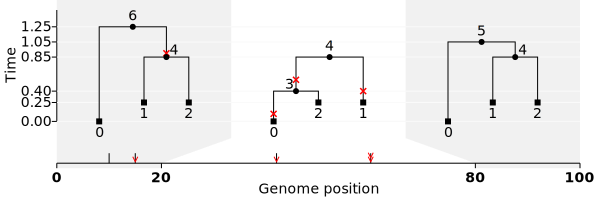

In [27]:
# Plot without mutation labels, for clarity 
altered_ts.draw_svg(y_axis=True, y_gridlines=True, mutation_labels={})

You can see that the new tree sequence has been modified as expected: there is a new
empty site at position 10 (represented by a tickmark above the X axis with no mutations
on it), and all the nodes except node 0 have had their times increased by 0.25.

(sec_tables_creating)=

## Constructing a tree sequence

With the tools above in mind, we can now see how to construct a tree sequence by hand.
It's unlikely that you would ever need to do this from scratch, but it's helpful to
understand how tables work. We'll build an extremely simple tree sequence, consisting of
a single tree that looks like this:

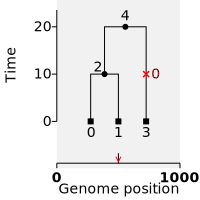

In [28]:
tskit.load("data/construction_example.trees").draw_svg(y_axis=True)

Starting with an empty set of tables, we can fill, say, the node information by using
{meth}`NodeTable.add_row` as follows:

In [29]:
tables = tskit.TableCollection(sequence_length=1e3)
node_table = tables.nodes  # set up an alias, for efficiency
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0: defaults to time 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1: defaults to time 0
node_table.add_row(time=10)  # Node 2: not a sample
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 3
node_table.add_row(time=20)  # Node 4
node_table

id,flags,population,individual,time,metadata
0,1,-1,-1,0,
1,1,-1,-1,0,
2,0,-1,-1,10,
3,1,-1,-1,0,
4,0,-1,-1,20,


The ``.add_row()`` method is natural (and should be reasonably efficient) if
new records appear one-by-one. Alternatively ``.set_columns()`` can be used to
set columns for all the rows at once, by passing in numpy arrays of the appropriate
type. We'll use that for the edges:

In [30]:
import numpy as np
edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0.0, 0.0, 0.0, 0.0]),
    right=np.array([1e3, 1e3, 1e3, 1e3]),
    parent=np.array([2, 2, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 2, 3], dtype=np.int32),  # References IDs in the node table
)
edge_table

id,left,right,parent,child,metadata
0,0,1000,2,0,
1,0,1000,2,1,
2,0,1000,4,2,
3,0,1000,4,3,


And finally we can add a site and a mutation: here we'll use 0/1 mutations rather than
ATGC.

A hand-built tree sequence!


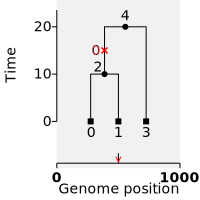

In [31]:
site_id = tables.sites.add_row(position=500.0, ancestral_state='0')
tables.mutations.add_row(site=site_id, node=2, derived_state='1')
ts = tables.tree_sequence()
print("A hand-built tree sequence!")
ts.draw_svg(y_axis=True)

:::{note}
The ordering requirements for a valid tree sequence
{ref}`do not specify<tskit:sec_node_requirements>` that rows in the
node table have to be sorted in any particular order, e.g. by time. By convention,
sample nodes are often the first ones listed in the node table, and this is the node
order returned by {meth}`~TreeSequence.simplify`, but the example above shows that
sample nodes need not necessarily be those with the IDs $0..n$.
:::

(sec_tables_editing)=

## Editing tree sequences

If you may wish to make modifications to a tree sequence, you will immediately encounter
a barrier: tree sequence objects are **immutable** and so cannot be edited in-place.
Therefore, the way to change a tree sequence is to edit its underlying tables.

Before providing further examples of how to edit tables, it's worth noting that
{program}`tskit` may provide a built-in method to achieve what you want to do, without
you having to think about the underlying tables at all. In particular, several methods
will return a new tree sequence that has been modified in some way. Here are some key
ones:

- {meth}`TreeSequence.delete_sites` returns a tree sequence with certain sites
  deleted
- {meth}`TreeSequence.delete_intervals` and {meth}`TreeSequence.keep_intervals` 
  return a tree sequence whose trees cover a smaller fraction of the genome (and which can
  be combined with {meth}`TreeSequence.trim` to change the coordinate system)
- {meth}`TreeSequence.simplify` returns a new tree sequence with some sample nodes removed
  (see the {ref}`simplification tutorial<sec_simplification>`).
- {meth}`TreeSequence.union` returns a new tree sequence formed by merging two other tree
  sequences together.

For example, to strip singleton sites from a tree sequence, we can simply call the
{meth}`TreeSequence.delete_sites` method:

In [32]:
import msprime
import numpy as np

ts = msprime.sim_ancestry(10, random_seed=123)
ts = msprime.sim_mutations(ts, rate=10, discrete_genome=False, random_seed=123)
print(ts.num_sites, "sites in the simulated tree sequence")

# Identify sites with a singleton allele
sites_with_a_singleton_allele = []
for v in ts.variants():
    non_missing_genotypes = v.genotypes[v.genotypes != tskit.MISSING_DATA]
    if np.any(np.bincount(non_missing_genotypes) == 1):
        sites_with_a_singleton_allele.append(v.site.id)
        
# Strip those sites from the tree sequence
ts_new = ts.delete_sites(sites_with_a_singleton_allele)
print(ts_new.num_sites, "sites after removing singletons")

109 sites in the simulated tree sequence
52 sites after removing singletons


However, you want to do something not covered by a built-in method, you will
need to edit a copy of the underlying tables and then create a new tree sequence from
the modified tables. 


(sec_tables_editing_minor)=

### Minor edits

{ref}`Previously<sec_tables_accessing_rows>` we saw how to change specific rows by
overwriting them. Here, for example, we use {meth}`IndividualTableRow.replace` to change
the `metadata` associated with an individual in one of our example tree sequences:

In [33]:
tables = altered_ts.dump_tables()
# Change the name "Bob" to "Robert"
tables.individuals[1] = tables.individuals[1].replace(metadata={"name": "Robert"})
edited_ts = tables.tree_sequence()
edited_ts.tables.individuals

id,flags,location,parents,metadata
0,0,,"2, -1",{'name': 'Alice'}
1,0,,"2, -1",{'name': 'Robert'}
2,0,,"-1, -1",{'name': 'Carol'}


If you are overwriting an entire column, especially something like metadata which is a
{ref}`ragged column<sec_encoding_ragged_columns>`, looping through each row and changing
it as above will not be very performant. Instead, you should overwrite the entire column
(or multiple columns) at once. We {ref}`previously saw<sec_tables_accessing_columns>`
how to overwrite an entire column of numbers, and for most columns that should suffice.
However, overwriting ragged columns like `metadata` or `parents` is more involved,
as you cannot set them to a single numpy array. Instead, for these columns, `tskit`
provides a number of `packset_` routines, which set the appropriate column from a Python
list of values.

Here's an example of changing an entire column of metadata in one pass (in this case,
note the extra step of validating and encoding before calling
{meth}`IndividualTable.packset_metadata`, as
{ref}`described<sec_tutorial_metadata_bulk>` in the
{ref}`metadata tutorial<sec_tutorial_metadata>`).

In [34]:
# Add a surname to all individuals
new_metadata = [{"name": i.metadata["name"] + " Smith"} for i in tables.individuals]
validated_metadata = [
    tables.individuals.metadata_schema.validate_and_encode_row(row) for row in new_metadata
]
tables.individuals.packset_metadata(validated_metadata)
edited_ts = tables.tree_sequence()
edited_ts.tables.individuals

id,flags,location,parents,metadata
0,0,,"2, -1",{'name': 'Alice Smith'}
1,0,,"2, -1",{'name': 'Robert Smith'}
2,0,,"-1, -1",{'name': 'Carol Smith'}


(sec_tables_editing_major)=

### Major edits

For larger changes, it is often worth clearing the entire table and filling it. Here,
for example, we clear all mutations from the mutations table, then fill it up again,
if possible using a more parsimonious placement of mutations (i.e. a placement that
would better explain the observed variation among samples - see the
{ref}`sec_analysing_trees_parsimony` tutorial section).
This also involves changing the ancestral state at the site if necessary.

In [35]:
# Make a tree sequence with loads of recurrent/back mutations, for testing only
ts = msprime.sim_ancestry(10, sequence_length=100, recombination_rate=0.1, random_seed=123)
ts = msprime.sim_mutations(ts, rate=0.1, random_seed=456)
print("Original ts has", ts.num_mutations, "mutations on", ts.num_trees, "trees")

tables = ts.dump_tables()  # Copy the table collection associated with this tree sequence
tables.mutations.clear()  # Clear all mutations in the table collection copy
v_iter = ts.variants()  # Workaround until https://github.com/tskit-dev/tskit/issues/605 is solved
for tree in ts.trees():
    for site in tree.sites():
        variant = next(v_iter)
        anc_state, mutations = tree.map_mutations(variant.genotypes, variant.alleles)
        if len(mutations) <  len(site.mutations):
            # Genotypes can be explained with a more parsimonious distribution of mutations
            if anc_state != site.ancestral_state:
                tables.sites[site.id] = tables.sites[site.id].replace(ancestral_state=anc_state)
            for mut in mutations:
                tables.mutations.append(mut.replace(site=site.id))            
        else:
            # Add the original mutations back in (note that parent ids may have changed,
            # so we will need to call compute_mutation_parents at the end)
            for mut in site.mutations:
                tables.mutations.append(mut)
tables.compute_mutation_parents()
tables.compute_mutation_times()
tables.sort()
parsimonious_ts = tables.tree_sequence()

print("Parsimonious ts has", ts.num_mutations - parsimonious_ts.num_mutations, "fewer muts")

# Optional checks
assert ts.num_trees == parsimonious_ts.num_trees
assert ts.num_sites == parsimonious_ts.num_sites
for v1, v2 in zip(ts.variants(), parsimonious_ts.variants()):
    # convert alleles to numpy arrays so we can index into them easily
    alleles1, alleles2 = np.array(v1.alleles), np.array(v2.alleles)
    # Verify the distribution of variation is the same, by comparing the allelic state
    assert np.all(alleles1[v1.genotypes] == alleles2[v2.genotypes])

Original ts has 154 mutations on 71 trees
Parsimonious ts has 33 fewer muts


:::{note}
In the code above we iterate over the trees in the original tree sequence, but make
changes to a *copy* of the tables associated with those trees, modifying the table
collection as we go. This is a common idiom.
:::